In [1]:
import healpy as hp
import numpy as np
import pylab as pl
import camb 
rot = hp.Rotator(coord=['C','G'])
from astropy.coordinates import SkyCoord
from astropy.io import fits
import pymaster as nmt
import sys
from scipy import stats
sys.path.append('/Users/gfabbian/Software/PolSpice_v03-07-05/bin')

# Preparing data

### Masks
Reads and rotate QSO masks, selection function in galactic coordinates. Read Planck masks

In [2]:
binmask_c = hp.read_map('../../mask_qso_binary_mcs_dust_Av0.2_NSIDE256.fits')
mask_c = hp.read_map('../../mask_qso_prob_NSIDE256.fits')
mask = rot.rotate_map_pixel(mask_c)
binmask = rot.rotate_map_pixel(binmask_c)

In [3]:
try:
    lensmask = hp.read_map('/Users/fabbian/Work/Planck/DR3/COM_Lensing-CIBcomb_2000_R3.00/inputs/mask.fits')
    galmask40 = hp.read_map('/Users/fabbian/Work/YxWxSCOSMOS/data/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=1)
    galmask = hp.read_map('/Users/fabbian/Work/YxWxSCOSMOS/data/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=2)    
except:
    lensmask = hp.read_map('/Users/gfabbian/Work/PR4_variations/mask.fits')
    galmask40 = hp.read_map('/Users/gfabbian/Work/quasar_gaia/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=1)
    galmask = hp.read_map('/Users/gfabbian/Work/quasar_gaia/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=2)        
     


### Resolution

Define resolution parameter for projections etc.

In [53]:
nside=256
beam = hp.pixwin(nside,lmax=3*nside-1,pol=False)

### Lensing

Read data and filter maps to match $\ell_{max}$ set by nside parameter of HEALPIX grid

In [95]:
# compute delta  and k

klm = hp.read_alm('../../dat_klm.fits')
klm = hp.read_alm('/Users/gfabbian/Work/PR4_variations/PR42018like_klm_dat_MV.fits') # read DR4 instead of DR3
fl=np.ones(4097)
fl[3*nside-1:]=0.
khr=hp.alm2map(hp.almxfl(klm,fl),nside=2048,pol=False)

### QSO

Read catalog , convert position to galactic coordinates and define a splits for computing jackknife. Compute number counts using mean computed over the footprint

In [96]:
# Prepare raw GAIA data
d=fits.open('../../gaia_G20.0.fits')

sc = SkyCoord(ra=d[1].data["ra"], dec=d[1].data["dec"], unit='deg', frame='icrs', equinox='J2000.0')
gs = sc.transform_to(frame='galactic')

pix = hp.ang2pix(nside,gs.l.value,gs.b.value,lonlat=True)
pix1 = hp.ang2pix(nside,gs.l.value[0::2],gs.b.value[0::2],lonlat=True)
pix2 = hp.ang2pix(nside,gs.l.value[1::2],gs.b.value[1::2],lonlat=True)

m=np.zeros(hp.nside2npix(nside))
m1=np.zeros(hp.nside2npix(nside))
m2=np.zeros(hp.nside2npix(nside))

for p in pix:
    m[p]+=1
for p in pix1:
    m1[p]+=1  
for p in pix2:
    m2[p]+=1    


In [97]:
nbar = np.mean(m[binmask!=0])
c = m/nbar -1

nbar1 = np.mean(m1[binmask!=0])
c1 = m1/nbar1 -1

nbar2 = np.mean(m2[binmask!=0])
c2 = m2/nbar2 -1

jk =(c2-c1)/2

print("nbar",nbar,np.mean(m))
print("nbar1",nbar1,np.mean(m1))
print("nbar2",nbar2,np.mean(m2))


nbar 1.2225455565615475 0.8250452677408854
nbar1 0.6112115686249506 0.4125226338704427
nbar2 0.611333987936597 0.4125226338704427


### Plotting

Displays data, footprint and redshift properties of catalog

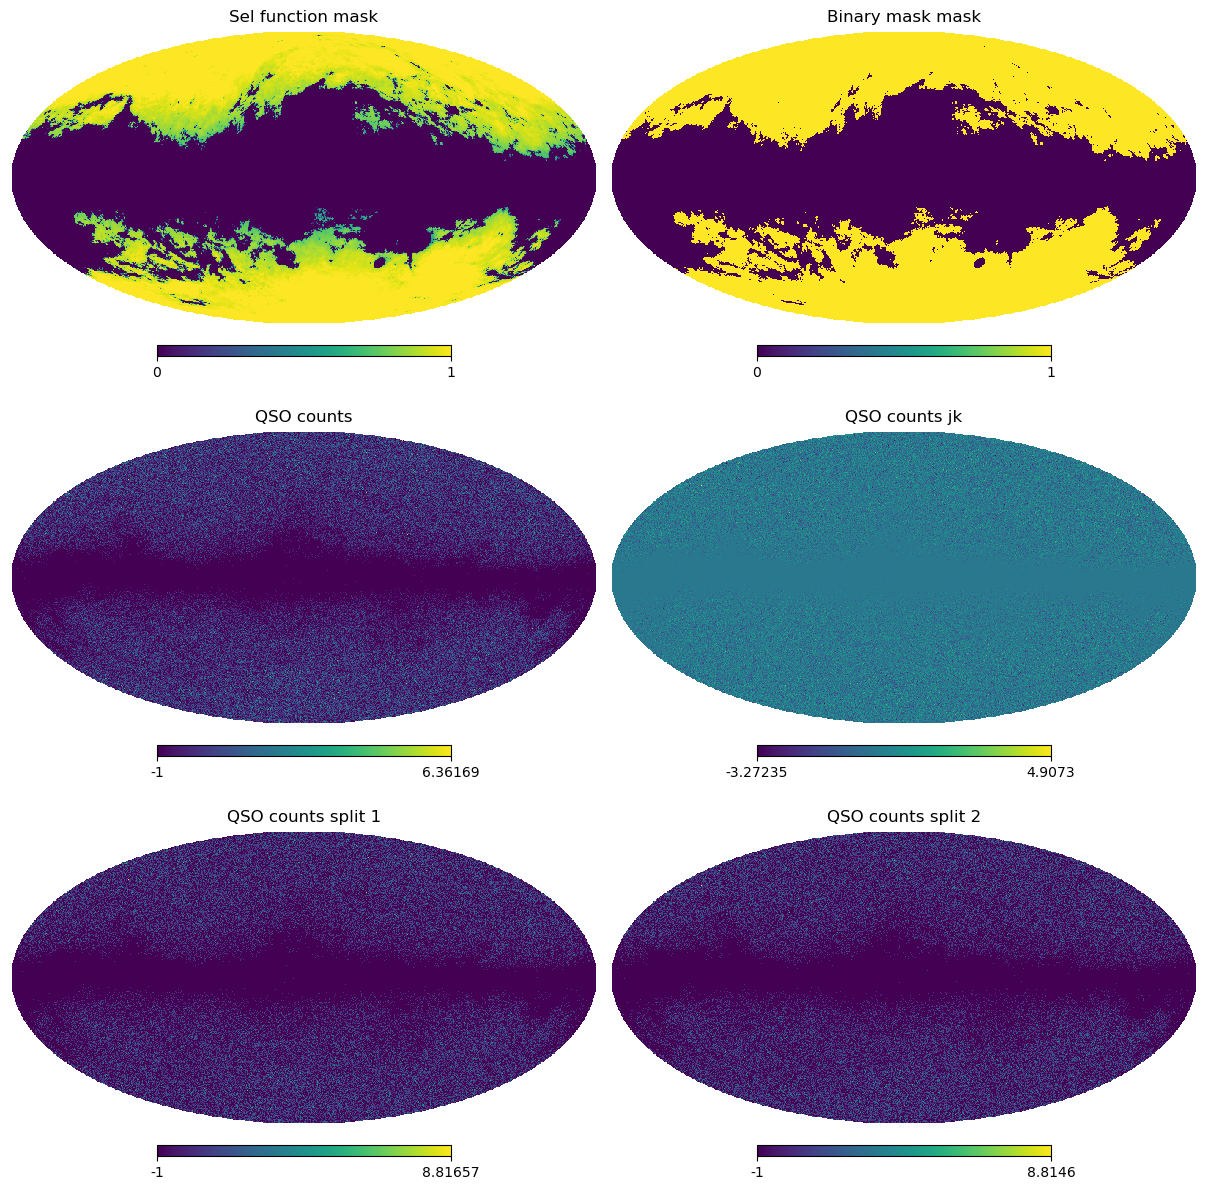

In [98]:
pl.figure(figsize=(12,12))
hp.mollview(mask,sub=321,title='Sel function mask')
hp.mollview(binmask,sub=322,title='Binary mask mask')
hp.mollview(c,sub=323,title='QSO counts')
hp.mollview(c1,sub=325,title='QSO counts split 1')
hp.mollview(c2,sub=326,title='QSO counts split 2')
hp.mollview(jk,sub=324,title='QSO counts jk')
pl.show()


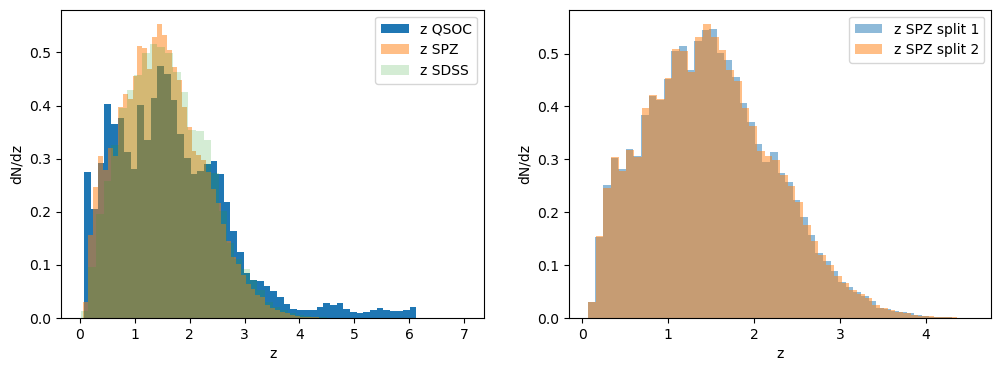

In [99]:
pl.figure(figsize=(12,4))
pl.subplot(1,2,1)
dndz_qsoc= pl.hist(d[1].data['redshift_qsoc'],bins=50,density=True,label='z QSOC')
dndz_spz= pl.hist(d[1].data['redshift_spz'],bins=50,density=True,alpha=0.5,label='z SPZ')
dndz_sdss= pl.hist(d[1].data['redshift_sdss'],bins=50,density=True,alpha=0.2,label='z SDSS')
pl.legend()
pl.xlabel('z')
pl.ylabel('dN/dz')
pl.subplot(1,2,2)
pl.hist(d[1].data['redshift_spz'][0::2],bins=50,density=True,alpha=0.5,label='z SPZ split 1')
pl.hist(d[1].data['redshift_spz'][1::2],bins=50,density=True,alpha=0.5,label='z SPZ split 2')
pl.xlabel('z')
pl.ylabel('dN/dz')
pl.legend()
pl.show()

# Theory model

Use $dN/dz$ to compute theory model using CAMB. Bias adopted from https://arxiv.org/pdf/1705.04718.pdf . In this model the median redshift of our sample should give a bias of around $b=2.45$

In [100]:
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow

dndz= pl.hist(d[1].data['redshift_spz'],bins=50)
pl.close()
#dndz= pl.hist(d[1].data['redshift_qsoc'],bins=50)
dndz=[np.diff(dndz[1])+dndz[1][:-1],dndz[0]]

# read dn/dz and normalize it
dndz[1]/=np.trapz(dndz[1],dndz[0])
#pl.plot(dndz[0],dndz[1])

pars = camb.CAMBparams()
lmax=1000
b_quasar=2.35

pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(lmax, lens_potential_accuracy=4)
##set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = True

##NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinear = model.NonLinear_both


#density only is the default
pars.SourceTerms.limber_windows = True
pars.SourceTerms.limber_phi_lmin = 300
pars.SourceTerms.counts_lensing = True
pars.SourceTerms.counts_density  = True
pars.SourceTerms.counts_redshift = True #weird problems at times
pars.SourceTerms.counts_radial   = True # negligible at l<10
pars.SourceTerms.counts_timedelay = True # negligible
pars.SourceTerms.counts_ISW = True #negligible
pars.SourceTerms.counts_velocity = True #negligible
pars.SourceTerms.counts_potential = True #negligible
pars.SourceTerms.counts_evolve = True # not sure what this is

##Set up W(z) window functions, later labelled W1 from Gaia dN/dz function.
W=np.array(dndz[1])
z=np.array(dndz[0])
pars.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z)), z=z, W=W,source_type='counts')]

results = camb.get_results(pars)

# In the returned dictionary P is the lensing potential and not deflection as in camb doc if raw_cl=True. 
# potentially related to CAMB version and fixed in later ones?
cmb = results.get_cmb_power_spectra(raw_cl=True,CMB_unit='muK')
cls = results.get_source_cls_dict(raw_cl=True) 



/var/folders/3c/k4c228y17_b7sq_m4m7gy8w80000gq/T/ipykernel_51284/1893565244.py:4: RuntimeWarning: divide by zero encountered in divide
  d2p=1/p2d
/var/folders/3c/k4c228y17_b7sq_m4m7gy8w80000gq/T/ipykernel_51284/1893565244.py:21: RuntimeWarning: invalid value encountered in divide
  rho = cls['PxW1']*p2k/np.sqrt(np.abs(cls['PxP']*(p2k**2)*cls['W1xW1']))


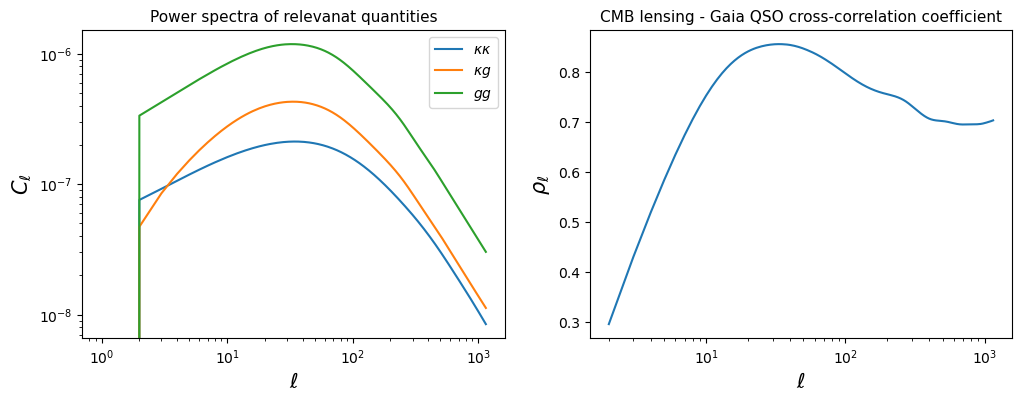

In [101]:
# plots power spectra
ls = np.arange(len(cls['PxP']))
p2d=np.sqrt(ls*(ls+1))
d2p=1/p2d
d2p[0:2]=0.0
d2k=p2d/2
p2k=(p2d**2/2)

pl.figure(figsize=(12,4))
pl.subplot(1,2,1)
pl.loglog(ls,cls['PxP']*p2k**2,label='$\kappa\kappa$')
pl.loglog(ls,cls['PxW1']*p2k,label='$\kappa g$') # should give kappaX for cross correlation
pl.loglog(ls,cls['W1xW1'],label='$gg$') 
pl.xlabel("$\ell$",size=15)
pl.ylabel("$C_\ell$",size=15)
pl.title("Power spectra of relevanat quantities",size=11)
pl.legend()


# compute correlation coefficient
rho = cls['PxW1']*p2k/np.sqrt(np.abs(cls['PxP']*(p2k**2)*cls['W1xW1']))
pl.subplot(1,2,2)
pl.semilogx(ls,np.abs(rho))
pl.xlabel("$\ell$",size=15)
pl.ylabel("$\\rho_\ell$",size=15)
pl.title("CMB lensing - Gaia QSO cross-correlation coefficient",size=11)
pl.show()

# Power spectrum estimation NAMASTER

### Data preparation
Define low resolution masks, apodizes them, downgrade lensing map to match QSO map. 

In [102]:
#khr_cl = hp.anafast(khr,lmax=4096,iter=1,pol=False)

binmask[binmask!=0]=1
apomask = nmt.mask_apodization(binmask,0.5, apotype="C2")
apomask_gal = nmt.mask_apodization(hp.ud_grade(galmask,nside_out=nside),1, apotype="C2")
apomask_gal40 = nmt.mask_apodization(hp.ud_grade(galmask40,nside_out=nside),1, apotype="C2")

klr = hp.ud_grade(khr,nside_out=nside)


Define binning, pseudo-power specturmc omputation function and function to compute all relevant quantities for a given mask and binning scheme

In [103]:


delta_b=20
b = nmt.NmtBin.from_nside_linear(nside, delta_b,is_Dell=False)
lb = b.get_effective_ells()

def compute_master(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

def compute_master_crosscorr_mask(apodized_mask,binning):
    # corrects for pixel window function
    beam = hp.pixwin(nside,lmax=3*nside-1,pol=False)
    
    f0 = nmt.NmtField(apodized_mask, [klr],beam=beam) # corrects for pixel window as klr computed from downgrade

    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f0, f0, binning)    

    f1 = nmt.NmtField( apodized_mask, [c],beam=beam)
    f11 = nmt.NmtField(apodized_mask, [c1],beam=beam)
    f12 = nmt.NmtField(apodized_mask, [c2],beam=beam)
    fjk = nmt.NmtField(apodized_mask, [jk],beam=beam)
    
    clkg = compute_master(f0, f1, w)[0]
    clgg = compute_master(f1, f1, w)[0]
    clkk = compute_master(f0, f0, w)[0]
    
    clkg1 = compute_master(f0, f11, w)[0]
    clg1g1 = compute_master(f11, f11, w)[0]
    
    clkg2 = compute_master(f0, f12, w)[0]
    clg2g2 = compute_master(f12, f12, w)[0]
    
    
    clg1g2 = compute_master(f11, f12, w)[0]
    clkgjk = compute_master(f0, fjk, w)[0]
    clgjk = compute_master(fjk, fjk, w)[0]
    
    cl_gg_th_binned = w.decouple_cell(w.couple_cell([cls['W1xW1']]))[0]
    cl_kg_th_binned = w.decouple_cell(w.couple_cell([cls['PxW1']*p2k]))[0]
    cl_kk_th_binned = w.decouple_cell(w.couple_cell([hp.alm2cl(klm)]))[0]    
    return clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk,cl_gg_th_binned,cl_kg_th_binned,cl_kk_th_binned


### Computation and plotting

In [104]:
analysis_mask = apomask_gal # avoids some of the auto correlation problem in bandpowers (more regular object)
clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk,cl_gg_th_binned,cl_kg_th_binned,cl_kk_th_binned = compute_master_crosscorr_mask(analysis_mask,b)

lmin 31.5
kg snr 18.402428213293827 snr th 22.115665179680335
kg chi2 0.8605750773364871 PTE 0.709368174924061
kg chi2 JK 1.1655504129127117 PTE 0.2257981826886869


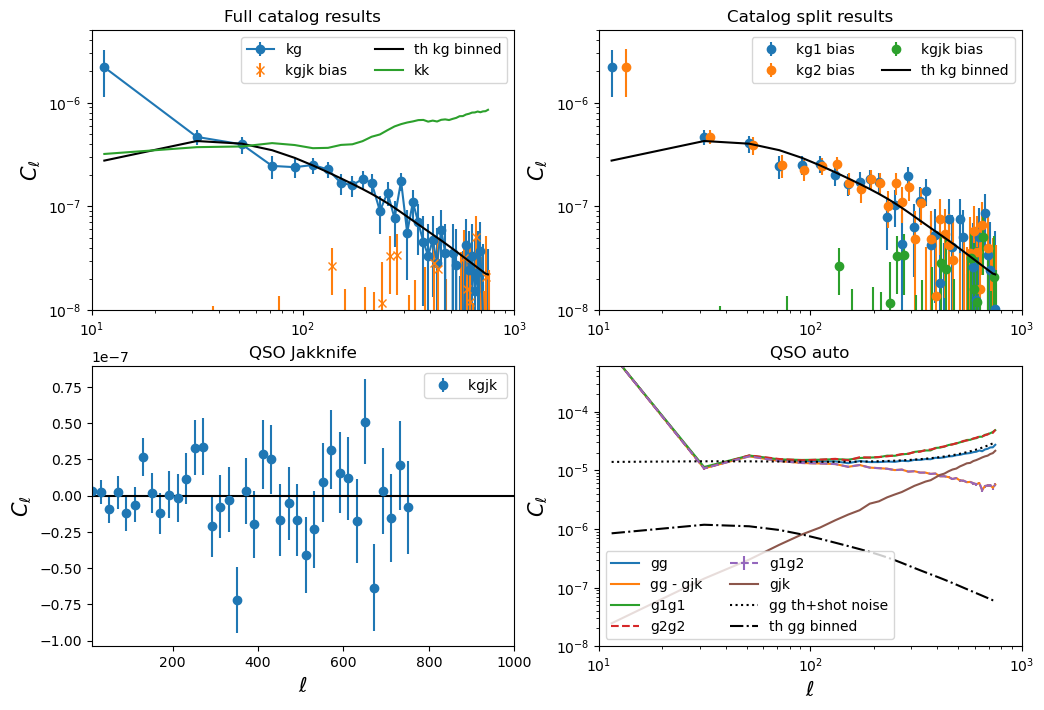

In [105]:

dkg = np.sqrt(clkk*clgg + clkg**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
dkg1 = np.sqrt(clkk*clg1g1 + clkg1**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
dkg2 = np.sqrt(clkk*clg2g2 + clkg2**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
dkgjk = np.sqrt(clkk*clgjk)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
dkg_th = np.sqrt(cl_kk_th_binned*clgg + clkg**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))

lbmin=1
chi2=((clkg-cl_kg_th_binned)/dkg)[lbmin:]**2
chi2jk=(clkgjk/dkgjk)[lbmin:]**2
snr = np.sqrt(np.cumsum(clkg[lbmin:]**2/dkg[lbmin:]**2)[-1])
snrth = np.sqrt(np.cumsum(clkg**2/dkg_th**2)[-1]) # uses theory error bar and not data-based estimates
print("lmin",lb[lbmin])
print("kg snr"%lb[lbmin],snr,'snr th',snrth)
print("kg chi2",np.mean(chi2),'PTE',1 - stats.chi2.cdf(np.sum(chi2), len(chi2)))
print("kg chi2 JK",np.mean(chi2jk),'PTE',1 - stats.chi2.cdf(np.sum(chi2jk), len(chi2jk)))

pl.figure(figsize=(12,8))
pl.subplot(2,2,1)
pl.errorbar(lb,clkg,dkg,label='kg',marker='o')
rescale = cl_kg_th_binned[1]/clkg[1]
pl.errorbar(lb+6,clkgjk,dkgjk,label='kgjk bias',marker='x',ls='')
#pl.errorbar(lb,clkg*rescale,dkg*rescale,label='kg bias rescaled',marker='o')
pl.errorbar(lb,cl_kg_th_binned,label='th kg binned',color='black',ls='-')
pl.errorbar(lb,clkk,label='kk')
#pl.errorbar(lb,cl_kk_th_binned,label='th kk binned') # from input alms 
pl.xscale("log")
pl.yscale("log")
pl.ylim(1e-08,5e-06)
pl.xlim(10,1000)
pl.legend(loc='best',ncol=2)
#pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell$',size=15)
pl.title("Full catalog results")
#pl.show()

# QSO splits CROSS-CORRELATION w/ Lensing
pl.subplot(2,2,2)
rescale = cl_kg_th_binned[1]/clkg[1]
pl.errorbar(lb,clkg1,dkg1,label='kg1 bias',marker='o',ls='')
pl.errorbar(lb+2,clkg2,dkg2,label='kg2 bias',marker='o',ls='')
pl.errorbar(lb+6,clkgjk,dkgjk,label='kgjk bias',marker='o',ls='')
#pl.errorbar(lb,clkg*rescale,dkg*rescale,label='kg bias rescaled',marker='o')
pl.errorbar(lb,cl_kg_th_binned,label='th kg binned',color='black',ls='-')
pl.xscale("log")
pl.yscale("log")
pl.ylim(1e-08,5e-06)
pl.xlim(10,1000)
pl.legend(loc='best',ncol=2)
#pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell$',size=15)
pl.title("Catalog split results")

# QSO JACKKNIFE CROSS-CORRELATION w/ Lensing
pl.subplot(2,2,3)
pl.errorbar(lb,clkgjk,dkgjk,label='kgjk ',marker='o',ls='')
pl.axhline(0,color='black')
pl.xlim(10,1000)
pl.legend(loc='best',ncol=2)
pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell$',size=15)
pl.title("QSO Jakknife")

         
# GALAXY AUTO    
shot_noise = (lb*hp.nside2resol(nside)**2*1/nbar/lb)/beam[lb.astype(np.int32)]**2
shot_noise1 = lb*hp.nside2resol(nside)**2*1/nbar1/lb/beam[lb.astype(np.int32)]**2
shot_noise2 = lb*hp.nside2resol(nside)**2*1/nbar2/lb/beam[lb.astype(np.int32)]**2

pl.subplot(2,2,4)
dgXg = np.sqrt(clg1g1*clg2g2 +clg1g2**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
pl.errorbar(lb,clgg,label='gg')
pl.errorbar(lb,clgg-clgjk,label='gg - gjk')
pl.errorbar(lb,clg1g1,label='g1g1',ls='-')
pl.errorbar(lb,clg2g2,label='g2g2',ls='--')
pl.errorbar(lb,clg1g2,yerr=dgXg,label='g1g2',ls='--')
pl.errorbar(lb,clgjk,label='gjk')
#pl.errorbar(lb,shot_noise,color='black',label='gg shot noise',ls=':')
pl.errorbar(lb,cl_gg_th_binned+shot_noise,color='black',label='gg th+shot noise',ls=':')
#pl.errorbar(lb,cl_gg_th_binned+shot_noise1,color='green',label='gg th+shot noise',ls=':')
#pl.errorbar(lb,cl_gg_th_binned+shot_noise2,color='red',label='gg th+shot noise',ls=':')
pl.errorbar(lb,cl_gg_th_binned,label='th gg binned',color='black',ls='-.')
#pl.errorbar(lb,(cl_gg_th_binned+clgjk),label='th gg binned +jk',color='black',ls='-.')
pl.xscale("log")
pl.yscale("log")
pl.ylim(1e-08,6e-04)
pl.xlim(10,1000)
pl.legend(loc='best',ncol=2)
pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell$',size=15)
pl.title("QSO auto")
pl.show()

In [106]:
len(d[1].data['redshift_spz'])

648842

# Power spectrum estimation PolSPICE

Todo